In [2]:
# Import modules
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

import pickle
from fcmeans import FCM
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import cm
from matplotlib.ticker import MaxNLocator

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency


import warnings
warnings.filterwarnings('ignore')

## Read Data
### No buffer

In [3]:
no_buffer_analysis_path = '../data_no_buffer_analysis_blocks'

no_buffer_imagery = pd.read_csv(os.path.join(no_buffer_analysis_path, 'df_imagery_analysis.csv'))
no_buffer_perception = pd.read_csv(os.path.join(no_buffer_analysis_path, 'df_perception_analysis.csv'))
no_buffer_vviq = pd.read_csv(os.path.join(no_buffer_analysis_path, 'df_vivid_analysis.csv'))
no_buffer_semantic = pd.read_csv(os.path.join(no_buffer_analysis_path, 'df_semantic_analysis.csv'))

### New stimulus

In [4]:
new_stimulus_analysis_path = '../data_new_stimulus_analysis_blocks'

new_stimulus_imagery = pd.read_csv(os.path.join(new_stimulus_analysis_path, 'df_imagery_analysis.csv'))
new_stimulus_perception = pd.read_csv(os.path.join(new_stimulus_analysis_path, 'df_perception_analysis.csv'))
new_stimulus_vviq = pd.read_csv(os.path.join(new_stimulus_analysis_path, 'df_vivid_analysis.csv'))
new_stimulus_semantic = pd.read_csv(os.path.join(new_stimulus_analysis_path, 'df_semantic_analysis.csv'))

### Online

In [5]:
online_analysis_path = '../data_online_analysis_blocks'

online_imagery = pd.read_csv(os.path.join(online_analysis_path, 'df_imagery_analysis.csv'))
online_perception = pd.read_csv(os.path.join(online_analysis_path, 'df_perception_analysis.csv'))
online_vviq = pd.read_csv(os.path.join(online_analysis_path, 'df_vivid_analysis.csv'))


### Combine 3 datasource and imagery and perception

In [6]:
no_buffer_imagery['IorP'] = 'Imagery'
no_buffer_perception['IorP'] = 'Perception'
new_stimulus_imagery['IorP'] = 'Imagery'
new_stimulus_perception['IorP'] = 'Perception'
online_imagery['IorP'] = 'Imagery'
online_perception['IorP'] = 'Perception'

df_all = pd.concat([no_buffer_imagery, no_buffer_perception, new_stimulus_imagery, new_stimulus_perception, online_imagery, online_perception]).reset_index(drop=True)

In [7]:
# normalize ans_rt and vividness_rt for each individual, combining imagery and perception
df_all['ans_rt_norm'] = df_all.groupby(['participant'])['ans_rt'].apply(lambda x: (x - x.mean()) / x.std())
df_all['vividness_rt_norm'] = df_all.groupby(['participant'])['vividness_rt'].apply(lambda x: (x - x.mean()) / x.std())
df_all['confidence_rt_norm'] = df_all.groupby(['participant'])['confidence_rt'].apply(lambda x: (x - x.mean()) / x.std())

In [8]:
df_cluster = df_all[['participant', 'field', 'IorP', 'ans_corr', 'vividness_key', 'ans_rt_norm', 'vividness_rt_norm', 'ans_rt', 'vividness_rt','confidence_key', 'confidence_rt', 'confidence_rt_norm']]

In [9]:
df_cluster_gb = df_cluster.groupby(['participant', 'IorP', 'field']).mean().reset_index()

In [10]:
df_cluster_gb.participant.nunique()

75

## Fuzzy-C Clustering

In [120]:
# standardize the data
data_for_cluster = df_cluster_gb.copy()
scaler = StandardScaler()
data_for_cluster[['ans_corr', 'ans_rt_norm']] = scaler.fit_transform(data_for_cluster[['ans_corr', 'ans_rt_norm']])
X = data_for_cluster[['ans_corr', 'ans_rt_norm']].values

In [121]:
cluster_results = df_cluster_gb.copy()

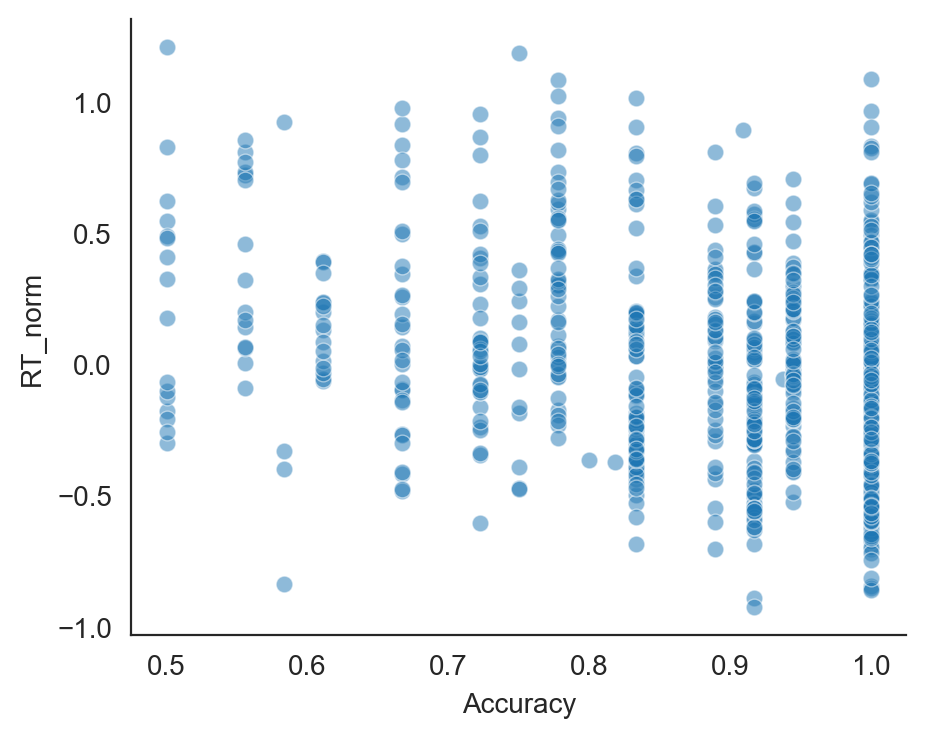

In [122]:
# plot the clusters
fig, ax = plt.subplots(figsize=(5, 4), dpi=200)
sns.scatterplot(x='ans_corr', y='ans_rt_norm', data=cluster_results, ax=ax, palette='colorblind', alpha=0.5)
plt.xlabel('Accuracy')
plt.ylabel('RT_norm')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [123]:
fcm = FCM(n_clusters=4)
fcm.fit(X)

fcm_labels = fcm.predict(X)

fcm_labels = [x+1 for x in fcm_labels]
cluster_results['cluster_fcm'] = fcm_labels

# plot the clusters
fig, ax = plt.subplots(figsize=(5, 4))
sns.scatterplot(x='ans_corr', y='ans_rt_norm', data=cluster_results, hue='cluster_fcm', ax=ax, palette='colorblind')
plt.xlabel('Accuracy')
plt.ylabel('RT_norm')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), title='Cluster')
plt.title('Fuzzy C Means Clustering')

cluster_results.to_csv('cluster_results.csv', index=False)

In [124]:
with open('fcm_model.pkl', 'rb') as f:
    fcm = pickle.load(f)
    
cluster_results = pd.read_csv('cluster_results.csv')

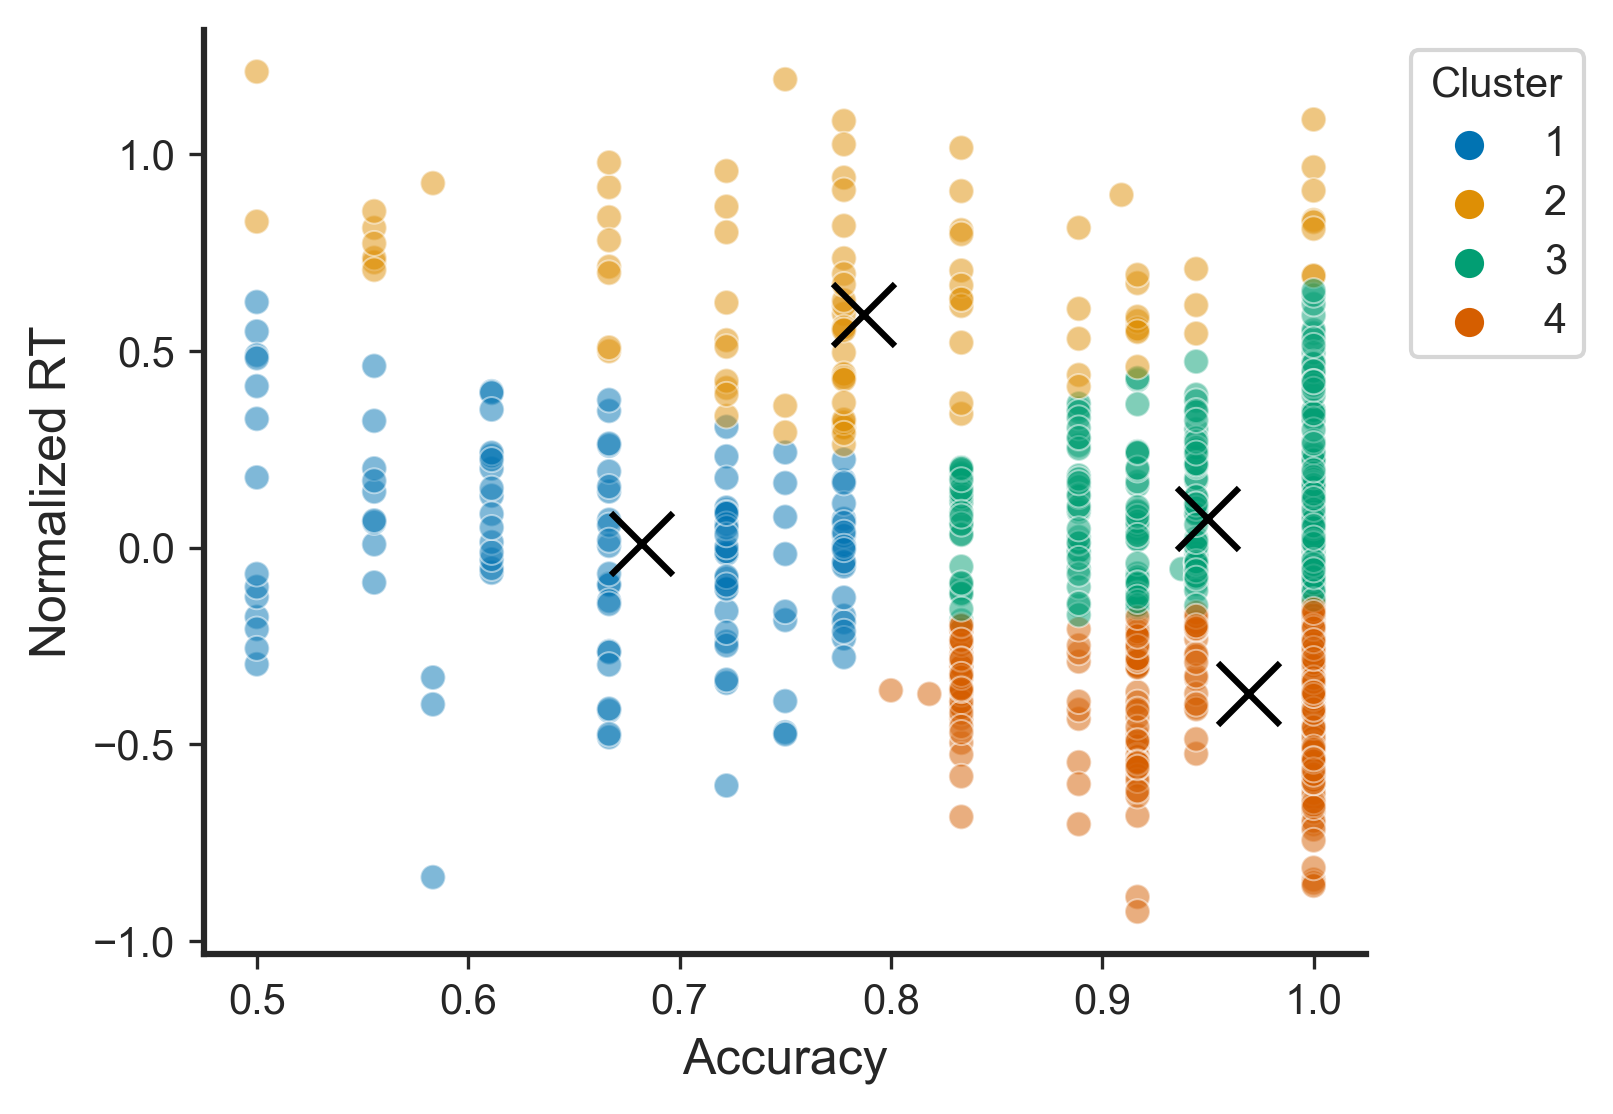

In [126]:
# also plot the centroids
centroids = fcm.centers
centroids = scaler.inverse_transform(centroids)

# plot the clusters
fig, ax = plt.subplots(figsize=(5, 4), dpi=300)
sns.scatterplot(x='ans_corr', y='ans_rt_norm', data=cluster_results, hue='cluster_fcm', ax=ax, palette='colorblind', alpha = 0.5)
for i in range(0, len(centroids)):
    plt.plot(centroids[i][0], centroids[i][1], 'x', color='black', markersize=15, markeredgewidth=1.5)

plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('Normalized RT', fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), title='Cluster')

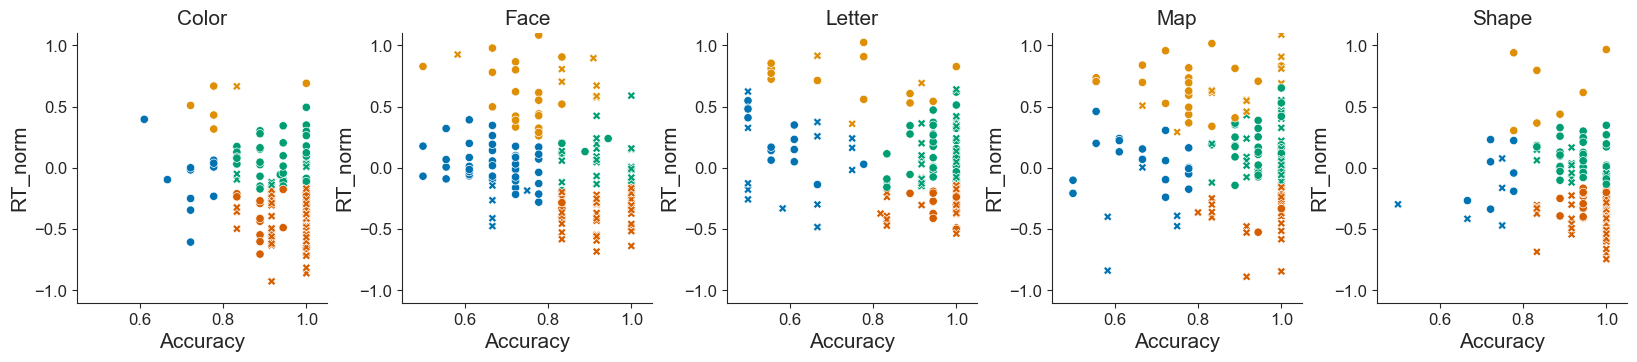

In [127]:
fig, ax = plt.subplots(1,5, figsize=(20, 3.5))
for i, domain in enumerate(cluster_results['field'].unique()):
    cluster_results_domain = cluster_results[cluster_results['field'] == domain]
    sns.scatterplot(x='ans_corr', y='ans_rt_norm', data=cluster_results_domain, hue='cluster_fcm', style = 'IorP' , ax=ax[i], palette='colorblind')
    ax[i].set_xlabel('Accuracy')
    ax[i].set_ylabel('RT_norm')
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_title(domain)
    ax[i].yaxis.set_ticks_position('left')
    ax[i].xaxis.set_ticks_position('bottom')
    
    ax[i].title.set_size(15)
    # font size for x and y labels and ticks
    ax[i].xaxis.label.set_size(15)
    ax[i].yaxis.label.set_size(15)
    ax[i].tick_params(axis='both', which='major', labelsize=12)

    
    ax[i].set_xlim(0.45, 1.05)
    ax[i].set_ylim(-1.1, 1.1)
    ax[i].set_yticks(np.arange(-1, 1.1, 0.5))
    # remove legend
    ax[i].get_legend().remove()
    
# add spaces between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

Text(0.5, 1.0, 'Fuzzy C Means Clustering - Face')

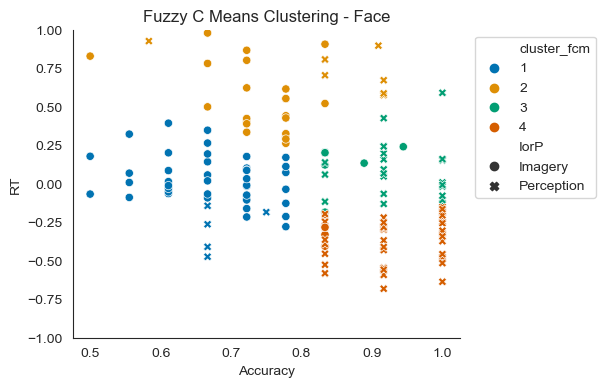

In [128]:
cluster_results_face = cluster_results[cluster_results['field'] == 'Face'] 

# plot the clusters
fig, ax = plt.subplots(figsize=(5, 4))
sns.scatterplot(x='ans_corr', y='ans_rt_norm', data=cluster_results_face, hue='cluster_fcm', ax=ax, palette='colorblind', style = 'IorP')
plt.xlabel('Accuracy')
plt.ylabel('RT')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.ylim(-1, 1)
plt.title('Fuzzy C Means Clustering - Face')

Text(0.5, 1.0, 'Fuzzy C Means Clustering - Color')

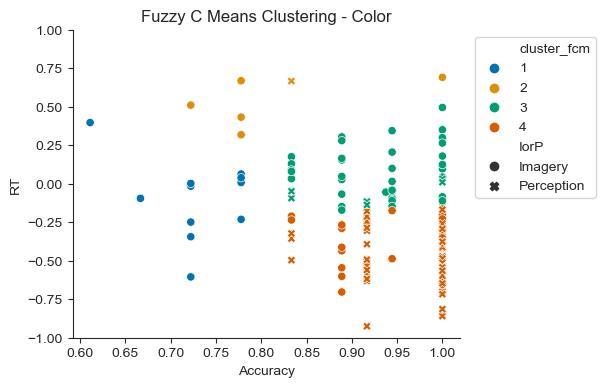

In [129]:
cluster_results_color = cluster_results[cluster_results['field'] == 'Color']

# plot the clusters
fig, ax = plt.subplots(figsize=(5, 4))
sns.scatterplot(x='ans_corr', y='ans_rt_norm', data=cluster_results_color, hue='cluster_fcm', ax=ax, palette='colorblind', style = 'IorP')
plt.xlabel('Accuracy')
plt.ylabel('RT')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.ylim(-1, 1)
plt.title('Fuzzy C Means Clustering - Color')

Text(0.5, 1.0, 'Fuzzy C Means Clustering - Shape')

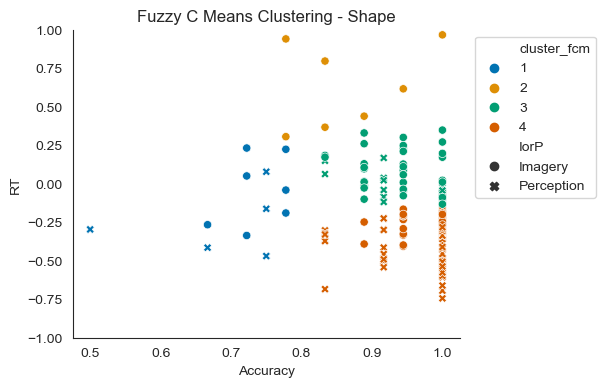

In [130]:
cluster_results_shape = cluster_results[cluster_results['field'] == 'Shape']

# plot the clusters
fig, ax = plt.subplots(figsize=(5, 4))
sns.scatterplot(x='ans_corr', y='ans_rt_norm', data=cluster_results_shape, hue='cluster_fcm', ax=ax, palette='colorblind', style = 'IorP')
plt.xlabel('Accuracy')
plt.ylabel('RT')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.ylim(-1, 1)
plt.title('Fuzzy C Means Clustering - Shape')

Text(0.5, 1.0, 'Fuzzy C Means Clustering - Letter')

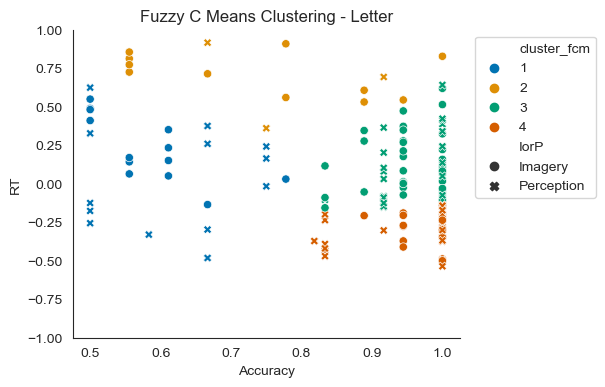

In [131]:
cluster_results_letter = cluster_results[cluster_results['field'] == 'Letter']

# plot the clusters
fig, ax = plt.subplots(figsize=(5, 4))
sns.scatterplot(x='ans_corr', y='ans_rt_norm', data=cluster_results_letter, hue='cluster_fcm', ax=ax, palette='colorblind', style = 'IorP')
plt.xlabel('Accuracy')
plt.ylabel('RT')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.ylim(-1, 1)
plt.title('Fuzzy C Means Clustering - Letter')

In [132]:
cluster_results = pd.read_csv('cluster_results.csv')
# contingency table for all clusters
for i in range(1, 5):
    print(f'Cluster {i}')
    cluster_i = cluster_results[cluster_results['cluster_fcm'] == i]
    cross_tab = pd.crosstab(cluster_i['IorP'], cluster_i['field'])
    print(cross_tab)
    print('')

Cluster 1
field       Color  Face  Letter  Map  Shape
IorP                                       
Imagery        11    43      13   18      7
Perception      0     5      13    5      5

Cluster 2
field       Color  Face  Letter  Map  Shape
IorP                                       
Imagery         5    23      12   21      7
Perception      1     7       3   14      0

Cluster 3
field       Color  Face  Letter  Map  Shape
IorP                                       
Imagery        37     5      32   32     39
Perception      9    23      31   32     14

Cluster 4
field       Color  Face  Letter  Map  Shape
IorP                                       
Imagery        22     4      18    4     22
Perception     65    40      28   24     56



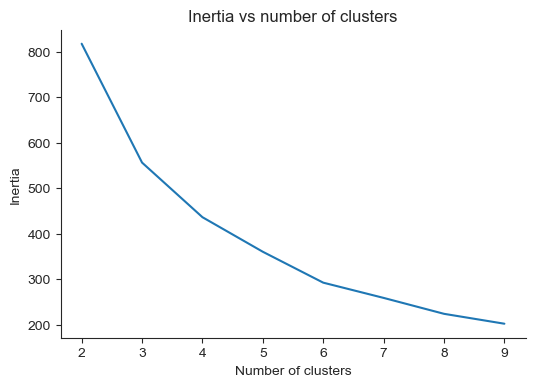

In [133]:
# elbow method for fuzzy c means
def cal_inertia(X, fcm):
    """
    Calculate inertia for fuzzy c means clustering
    """
    centers = fcm.centers
    labels = fcm.u.argmax(axis=1)
    inertia = 0
    for i in range(0, len(X)):
        inertia += np.linalg.norm(X[i] - centers[labels[i]]) ** 2
    return inertia

inertias = []

for k in range(2, 10):
    fcm_tmp = FCM(n_clusters=k)
    fcm_tmp.fit(X)
    inertias.append(cal_inertia(X, fcm_tmp))
    
fig, ax = plt.subplots(figsize=(6, 4))
# remove right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.plot(range(2, 10), inertias)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# add tick marks for x and y axis
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs number of clusters')

plt.show()


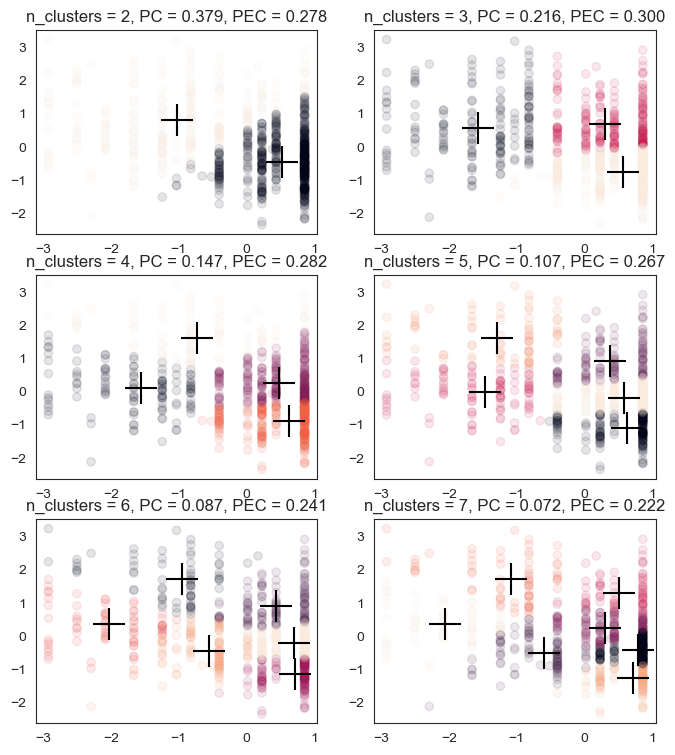

In [134]:
n_clusters_list = [2, 3, 4, 5, 6, 7]
models = list()
for n_clusters in n_clusters_list:
    fcm_tmp = FCM(n_clusters=n_clusters)
    fcm_tmp.fit(X)
    models.append(fcm_tmp)

# outputs
num_clusters = len(n_clusters_list)
rows = int(np.ceil(np.sqrt(num_clusters)))
cols = int(np.ceil(num_clusters / rows))
f, axes = plt.subplots(rows, cols, figsize=(8,9))
for n_clusters, model, axe in zip(n_clusters_list, models, axes.ravel()):
    # get validation metrics
    pc = model.partition_coefficient
    pec = model.partition_entropy_coefficient
    
    fcm_centers = model.centers
    fcm_labels = model.predict(X)
    
    # plot result
    axe.scatter(X[:,0], X[:,1], c=fcm_labels, alpha=.1)
    axe.scatter(fcm_centers[:,0], fcm_centers[:,1], marker="+", s=500, c='black')
    axe.set_title(f'n_clusters = {n_clusters}, PC = {pc:.3f}, PEC = {pec:.3f}')
plt.show()

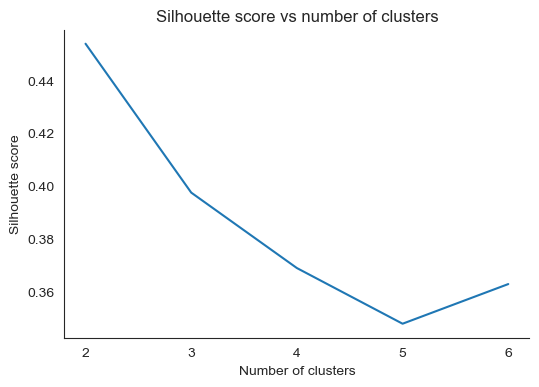

In [64]:
k_range = range(2, 7)
scores = []
for k in k_range:
    fcm = FCM(n_clusters=k)
    fcm.fit(X)
    scores.append(silhouette_score(X, fcm.u.argmax(axis=1)))
    
fig, ax = plt.subplots(figsize=(6, 4))
# remove right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(range(2, 7), scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score vs number of clusters')

plt.show()

For n_clusters = 2, the average silhouette score is 0.45386596593281425


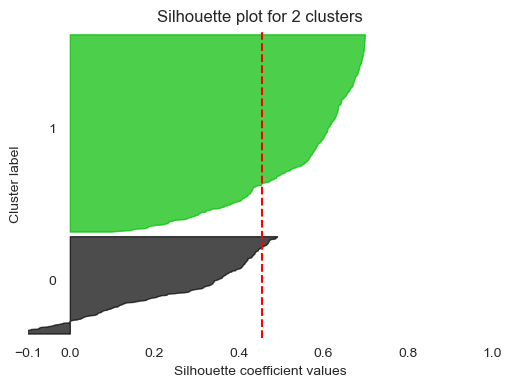

For n_clusters = 3, the average silhouette score is 0.39762120964013964


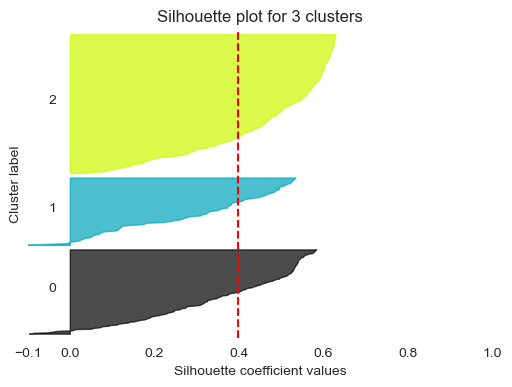

For n_clusters = 4, the average silhouette score is 0.3671612392690404


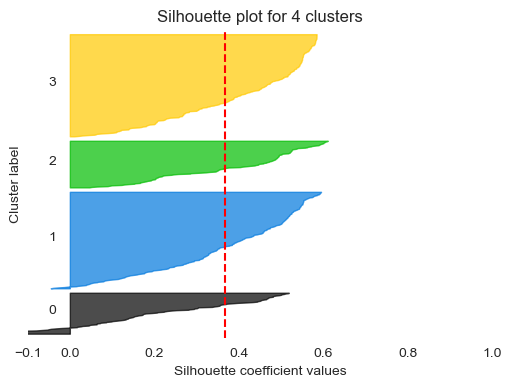

For n_clusters = 5, the average silhouette score is 0.35571203381689614


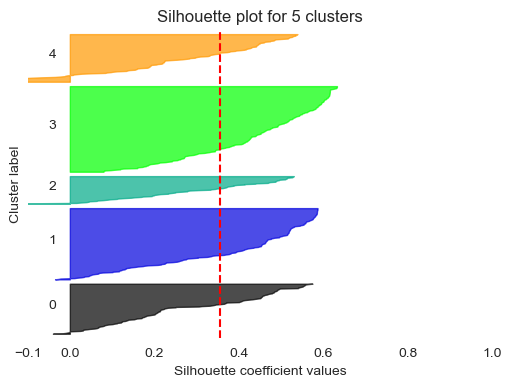

For n_clusters = 6, the average silhouette score is 0.3630662285531639


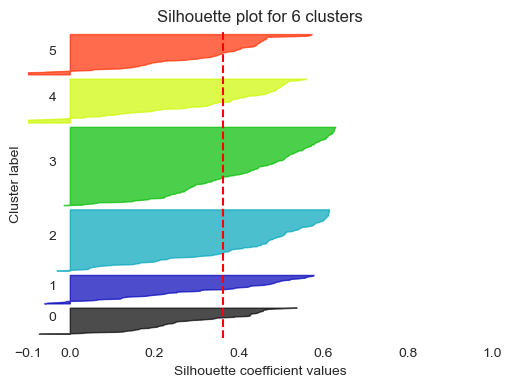

For n_clusters = 7, the average silhouette score is 0.3606107985790771


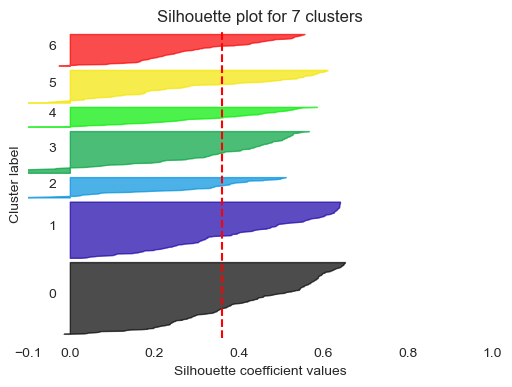

In [65]:
# silhouette graph for fuzzy c means
k_values = [2, 3, 4, 5, 6, 7]

def plot_silhouette_graph(n_cluster, X):
    fcm = FCM(n_clusters=n_cluster)
    fcm.fit(X)
    labels = fcm.u.argmax(axis=1)
    silhouette_avg = silhouette_score(X, labels)
    print(f'For n_clusters = {n_cluster}, the average silhouette score is {silhouette_avg}')
    sample_silhouette_values = silhouette_samples(X, labels)
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X) + (n_cluster + 1) * 10])
    y_lower = 10
    for i in range(n_cluster):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_cluster)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    ax.set_xlabel('Silhouette coefficient values')
    ax.set_ylabel('Cluster label')
    ax.axvline(x=silhouette_avg, color='red', linestyle='--')
    ax.set_yticks([])
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    for spine in ['right', 'top', 'left', 'bottom']:
        ax.spines[spine].set_visible(False)
    plt.title(f'Silhouette plot for {n_cluster} clusters')
    plt.show()
    
for k in k_values:
    plot_silhouette_graph(k, X)
    
  


## Hypothesis Testing

### All domains

In [66]:
cluster_results_ct = pd.crosstab(cluster_results['IorP'], cluster_results['cluster_fcm'])
print(cluster_results_ct)

cluster_fcm   1   2    3    4
IorP                         
Imagery      88  74  131   62
Perception   28  28  109  190


In [67]:
# chi square test for the contingency table
chi2, p, dof, expected = chi2_contingency(cluster_results_ct)

print(f'Chi2: {chi2}')
print(f'p-value: {p}')
print(f'dof: {dof}')
print(f'expected: {expected}')


Chi2: 118.81212048037605
p-value: 1.390773857670433e-25
dof: 3
expected: [[ 58.  51. 120. 126.]
 [ 58.  51. 120. 126.]]


### Shape

In [105]:
print('Shape')
cluster_results_shape_ct = pd.crosstab(cluster_results_shape['IorP'], cluster_results_shape['cluster_fcm'])
print(cluster_results_shape_ct)

# chi square test for the contingency table
chi2, p, dof, expected = chi2_contingency(cluster_results_shape_ct)

print(f'Chi2: {chi2}')
print(f'p-value: {p}')
print(f'dof: {dof}')
print(f'expected: {expected}')

Shape
cluster_fcm  1  2   3   4
IorP                     
Imagery      6  9  37  19
Perception   5  0  13  53
Chi2: 36.66646464646465
p-value: 5.4131115450961715e-08
dof: 3
expected: [[ 5.5  4.5 25.  36. ]
 [ 5.5  4.5 25.  36. ]]


### Color

In [106]:
cluster_results_color_ct = pd.crosstab(cluster_results_color['IorP'], cluster_results_color['cluster_fcm'])
print(cluster_results_color_ct)

chi2, p, dof, expected = chi2_contingency(cluster_results_color_ct)
print(f'Chi2: {chi2}')
print(f'p-value: {p}')
print(f'dof: {dof}')
print(f'expected: {expected}')


cluster_fcm   1  2   3   4
IorP                      
Imagery      10  5  34  22
Perception    0  1  12  58
Chi2: 39.38840579710145
p-value: 1.4360659733706266e-08
dof: 3
expected: [[ 5.  3. 23. 40.]
 [ 5.  3. 23. 40.]]


### Face

In [107]:
cluster_results_face_ct = pd.crosstab(cluster_results_face['IorP'], cluster_results_face['cluster_fcm'])
print(cluster_results_face_ct)

chi2, p, dof, expected = chi2_contingency(cluster_results_face_ct)
print(f'Chi2: {chi2}')
print(f'p-value: {p}')
print(f'dof: {dof}')
print(f'expected: {expected}')



cluster_fcm   1   2   3   4
IorP                       
Imagery      41  22   4   4
Perception    5   9  20  37
Chi2: 70.85316822312683
p-value: 2.8025567781136657e-15
dof: 3
expected: [[23.  15.5 12.  20.5]
 [23.  15.5 12.  20.5]]


### Map

In [108]:
cluster_results_map = cluster_results[cluster_results['field'] == 'Map']

cluster_results_map_ct = pd.crosstab(cluster_results_map['IorP'], cluster_results_map['cluster_fcm'])
print(cluster_results_map_ct)

chi2, p, dof, expected = chi2_contingency(cluster_results_map_ct)
print(f'Chi2: {chi2}')
print(f'p-value: {p}')
print(f'dof: {dof}')
print(f'expected: {expected}')




cluster_fcm   1   2   3   4
IorP                       
Imagery      18  23  26   4
Perception    5  14  32  20
Chi2: 20.824371597984793
p-value: 0.00011449779600980718
dof: 3
expected: [[11.5 18.5 29.  12. ]
 [11.5 18.5 29.  12. ]]


### Letter

In [109]:
cluster_results_letter = cluster_results[cluster_results['field'] == 'Letter']

cluster_results_letter_ct = pd.crosstab(cluster_results_letter['IorP'], cluster_results_letter['cluster_fcm'])
print(cluster_results_letter_ct)

chi2, p, dof, expected = chi2_contingency(cluster_results_letter_ct)
print(f'Chi2: {chi2}')
print(f'p-value: {p}')
print(f'dof: {dof}')
print(f'expected: {expected}')


cluster_fcm   1   2   3   4
IorP                       
Imagery      13  15  30  13
Perception   13   4  32  22
Chi2: 8.747222895949552
p-value: 0.03284751065842219
dof: 3
expected: [[13.   9.5 31.  17.5]
 [13.   9.5 31.  17.5]]
